In [81]:
%%time
%matplotlib inline
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.grid_search import RandomizedSearchCV
from catboost import CatBoostClassifier,CatBoostRegressor

from rgf.sklearn import RGFClassifier,RGFRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV,Ridge

Wall time: 5 ms


In [2]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [12]:
os.chdir(r'C:\Users\royal\Downloads\wns')
train =pd.read_csv('train_LZdllcl.csv')
test = pd.read_csv('test_2umaH9m.csv')
sub = pd.read_csv('sample_submission_M0L0uXE.csv')

In [33]:
os.chdir(r'C:\Users\royal\Downloads\wns')
train =pd.read_csv('train_with_ratings.csv')
test = pd.read_csv('test_with_ratings.csv')
sub = pd.read_csv('sample_submission_M0L0uXE.csv')

In [34]:
train.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [35]:
train.shape
test.shape

(54808, 14)

(23490, 13)

In [70]:
for i in train.columns:
    print(i,train[i].unique())

employee_id [65438 65141  7513 ..., 13918 13614 51526]
department [7 4 8 0 6 5 1 2 3]
region [31 14 10 15 18 11 12 27  0 28 21 24  6  5  2 29 20  8  4  7 17  1 19 23  3
 13 32 25 30 26 16 22 33  9]
education [  3.   2.  nan   1.]
gender [0 1]
recruitment_channel [2 0 1]
no_of_trainings [ 1  2  3  4  7  5  6  8 10  9]
age [35 30 34 39 45 31 33 28 32 49 37 38 41 27 29 26 24 57 40 42 23 59 44 50 56
 20 25 47 36 46 60 43 22 54 58 48 53 55 51 52 21]
previous_year_rating [  5.   3.   1.   4.  nan   2.]
length_of_service [ 8  4  7 10  2  5  6  1  3 16  9 11 26 12 17 14 13 19 15 23 18 20 22 25 28
 24 31 21 29 30 34 27 33 32 37]
KPIs_met >80% [1 0]
awards_won? [0 1]
avg_training_score [49 60 50 73 85 59 63 83 54 77 80 84 51 46 75 57 70 68 79 44 72 61 48 58 87
 47 52 88 71 65 62 53 78 91 82 69 55 74 86 90 92 67 89 56 76 81 45 64 39 94
 93 66 95 42 96 40 99 43 97 41 98]
is_promoted [0 1]
sum_metric [  6.   5.   3.   1.   4.  nan   2.   7.]
tot_score [ 49  60  50 100  73 170  59  63  83  54  77 16

In [37]:
train['education'].replace(np.nan,"Bachelor's",inplace=True)
test['education'].replace(np.nan,"Bachelor's",inplace=True)

In [38]:
train['education'].replace("Master's & above",3,inplace=True)
test['education'].replace("Master's & above",3,inplace=True)
train['education'].replace("Bachelor's",2,inplace=True)
test['education'].replace("Bachelor's",2,inplace=True)
train['education'].replace("Below Secondary",1,inplace=True)
test['education'].replace("Below Secondary",1,inplace=True)

In [15]:
train['previous_year_rating'].replace(np.nan,3.,inplace=True)
test['previous_year_rating'].replace(np.nan,3.,inplace=True)

In [39]:
train['sum_metric'] = train['awards_won?']+train['KPIs_met >80%'] + train['previous_year_rating']
test['sum_metric'] = test['awards_won?']+test['KPIs_met >80%'] + test['previous_year_rating']

train['tot_score'] = train['avg_training_score'] * train['no_of_trainings']
test['tot_score'] = test['avg_training_score'] * test['no_of_trainings']

In [69]:
train[train['is_promoted']==1].groupby('previous_year_rating')['is_promoted'].count()
train.groupby('previous_year_rating')['is_promoted'].count()

previous_year_rating
1.0      88
2.0     181
3.0    1355
4.0     784
5.0    1921
Name: is_promoted, dtype: int64

previous_year_rating
1.0     6223
2.0     4225
3.0    18618
4.0     9877
5.0    11741
Name: is_promoted, dtype: int64

In [36]:
train.isna().sum()
test.isna().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating       0
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating       0
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

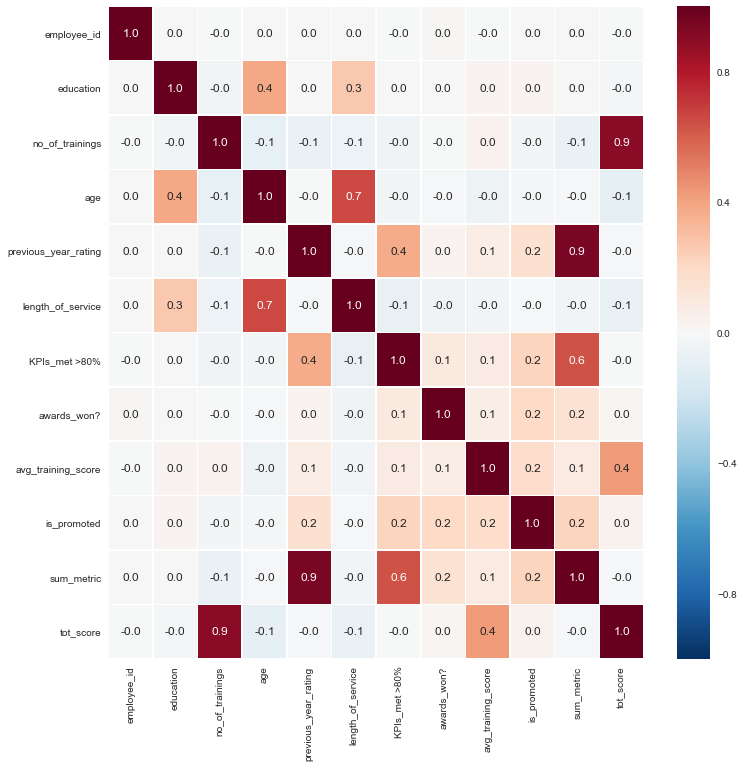

In [40]:
f,ax=plt.subplots(figsize=(12,12))
sns.heatmap(train.corr(),annot=True,linewidths=.5,fmt='.1f',ax=ax)

In [13]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

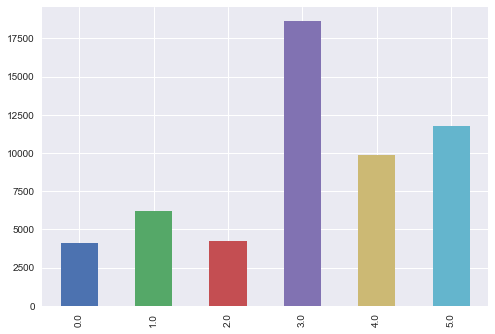

In [40]:
train['previous_year_rating'].value_counts().sort_index().head(50).plot.bar()

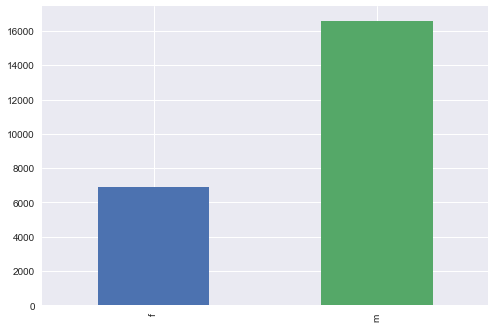

In [33]:
test['gender'].value_counts().sort_index().head(20).plot.bar()

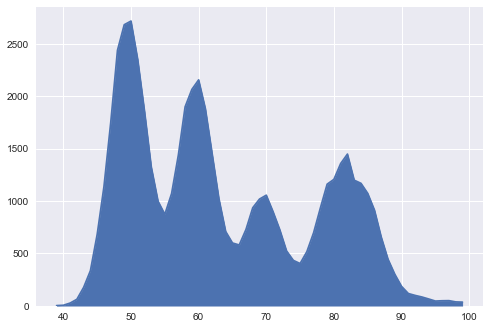

In [28]:
train['avg_training_score'].value_counts().sort_index().plot.area()

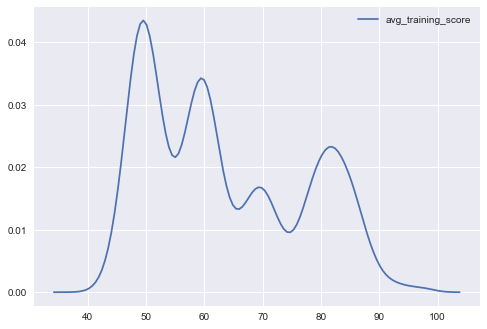

In [31]:
sns.kdeplot(train['avg_training_score'])

In [21]:
test.isnull().sum().sum()

2846

C:\Users\royal\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


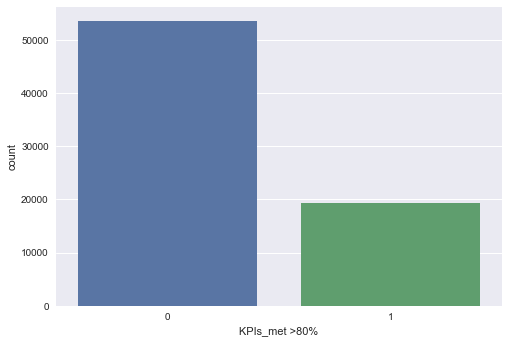

In [27]:
# sns.countplot(train['awards_won?'])
sns.countplot(train['KPIs_met >80%'])


C:\Users\royal\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


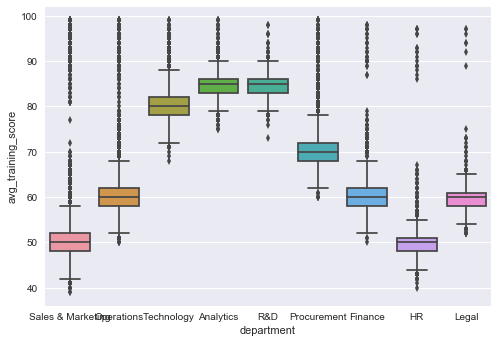

In [35]:
df= train[train.department.isin(train.department.value_counts().head(10).index)]
sns.boxplot(x='department',y='avg_training_score',data=df)

C:\Users\royal\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


C:\Users\royal\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


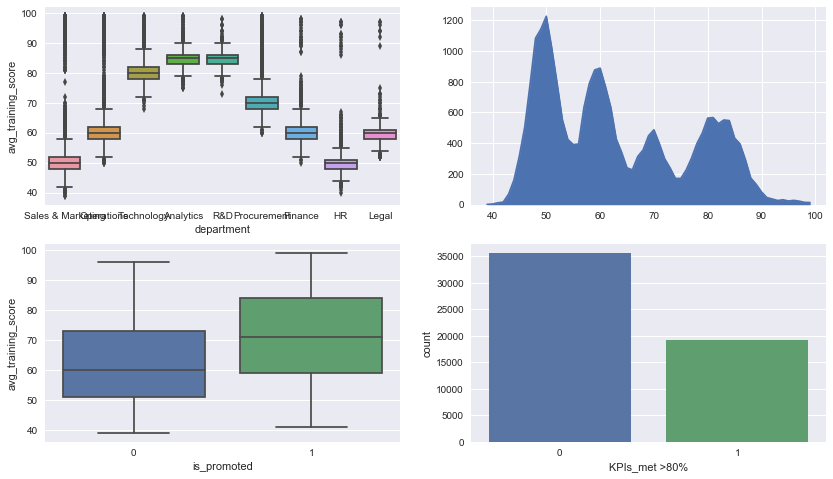

In [52]:
##can assign the each chart to one axes at a time
fig,axrr=plt.subplots(2,2,figsize=(14,8))

df= train[train.department.isin(train.department.value_counts().head(10).index)]
sns.boxplot(x='department',y='avg_training_score',data=df,ax=axrr[0][0])

# reviews['points'].value_counts().sort_index().plot.bar(ax=axrr[0][0])
# axrr[0][0].set_title('wine score',fontsize=18)

test['avg_training_score'].value_counts().sort_index()[:1000].plot.area(ax=axrr[0][1])
# sns.kdeplot(reviews[reviews['price'] < 200]['price'],ax=axrr[0][1])
# axrr[0][1].set_title('Price under 200',fontsize=18)

sns.boxplot(x='is_promoted',y='avg_training_score',data=train,ax=axrr[1][0])
# sns.countplot(reviews['points'],ax=axrr[1][0])

sns.countplot(train['KPIs_met >80%'],ax=axrr[1][1])
# reviews['province'].value_counts().head(20).plot.bar(ax=axrr[1][1])

In [41]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train['department'] = le.fit_transform(train['department'])
test['department'] = le.transform(test['department'])

In [42]:
train['region'] = le.fit_transform(train['region'])
test['region'] = le.transform(test['region'])
# train['education'] = le.fit_transform(train['education'])
# test['education'] = le.transform(test['education'])
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.transform(test['gender'])

train['recruitment_channel'] = le.fit_transform(train['recruitment_channel'])
test['recruitment_channel'] = le.transform(test['recruitment_channel'])

In [116]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,tot_score
0,65438,7,31,3.0,0,2,1,35,5.0,8,1,0,49,0,6.0,49
1,65141,4,14,2.0,1,0,1,30,5.0,4,0,0,60,0,5.0,60
2,7513,7,10,2.0,1,2,1,34,3.0,7,0,0,50,0,3.0,50
3,2542,7,15,2.0,1,0,2,39,1.0,10,0,0,50,0,1.0,100
4,48945,8,18,2.0,1,0,1,45,3.0,2,0,0,73,0,3.0,73


In [43]:
Y1=train['is_promoted']
# train1=train.drop(['employee_id','is_promoted'],axis=1)
train1=train.drop(['employee_id','is_promoted','recruitment_channel'],axis=1)
train1=train1.values
Y=Y1.values

test_id=test['employee_id']
# test1 = test.drop(['employee_id'],axis=1)
test1 = test.drop(['employee_id','recruitment_channel'],axis=1)
test1=test1.values

In [262]:
# enc = OneHotEncoder()
# enc.fit(train1)
# train2_one = enc.transform(train1)
# test2_one = enc.transform(test1)

# pca = PCA(n_components=1)
# pca.fit(train2_one.toarray())
# train_pca = pca.transform(train2_one.toarray())
# test_pca = pca.transform(test2_one.toarray())
# train3=np.column_stack((train2,train_pca))
# test3=np.column_stack((test2,test_pca))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

,principal component 1,principal component 2,is_promoted
0,1.932741,-1.914354,0
1,1.074727,-0.114583,0
2,-1.128013,-0.754061,0
3,-3.028559,0.583097,0
4,-0.929886,-0.149515,0


Text(0.5,0,'Principal Component 1')

Text(0,0.5,'Principal Component 2')

Text(0.5,1,'2 Component PCA')

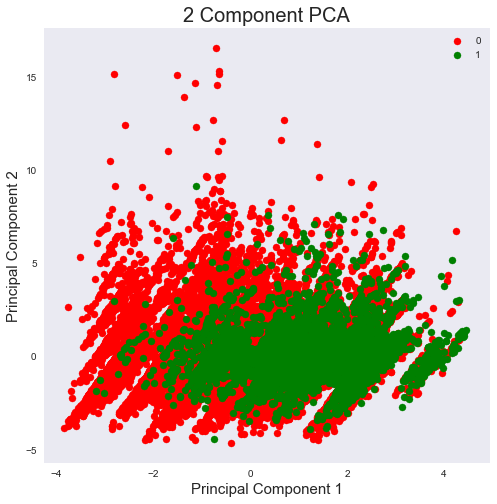

In [47]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train2)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, train.is_promoted], axis = 1)
finalDf.head(5)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['is_promoted'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [45]:
pca = PCA(n_components=1)
pca.fit(train2)
train_pca = pca.transform(train2)
test_pca = pca.transform(test2)
train3=np.column_stack((train2,train_pca))
test3=np.column_stack((test2,test_pca))

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [247]:
train3.shape

(54808, 14)

In [181]:
# ##feature selection to get important features only.
# sel = VarianceThreshold(threshold=.1)
# sel.fit(train2)
# train_thres = sel.transform(train2)
# test_thres = sel.transform(test2)

# train3=np.column_stack((train3,train_thres))
# test3=np.column_stack((test3,test_thres))

VarianceThreshold(threshold=0.1)

In [44]:
scaler = StandardScaler()
scaler.fit(train1)
# Apply transform to both the training set and the test set.
train2 = scaler.transform(train1)
test2 = scaler.transform(test1)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
# min_max_scaler = preprocessing.FunctionTransformer(np.log1p)
# train2 = min_max_scaler.transform(train1)
# test2 = min_max_scaler.transform(test1)

In [61]:
#create the cross validation fold for different boosting and linear model.
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
SEED=42
# clf = lgb.LGBMClassifier()
st_train = train3
st_test = test3
# clf = xgb.XGBClassifier()
# clf = RandomForestClassifier(max_depth=4, random_state=0)
# clf = lgb.LGBMClassifier(max_depth= 8, learning_rate=0.0941, n_estimators=197, num_leaves= 17, reg_alpha=3.4492 , reg_lambda= 0.0422) #lgb_pca
#clf = lgb.LGBMClassifier(max_depth= 8, learning_rate=0.0941, n_estimators=197, num_leaves= 17, reg_alpha=3.4492 , reg_lambda= 0.0422) #lgb_pca
# clf = lgb.LGBMClassifier(max_depth= 6, learning_rate=0.0527, n_estimators=396, num_leaves= 18, reg_alpha=2.3683 , reg_lambda= 0.0152) #lgb_pca

# clf=ExtraTreesClassifier(n_estimators=10000, criterion='entropy', max_depth=9,  min_samples_leaf=1,  n_jobs=30, random_state=1)
clf = xgb.XGBClassifier(gamma = 0.7233,learning_rate = 0.0480,max_depth = 10,min_child_weight = 2,n_estimators = 450)
# clf = RGFClassifier(max_leaf=500,algorithm="RGF",test_interval=100, loss="LS")

fold = 8
cv = StratifiedKFold(Y, n_folds=fold,shuffle=True, random_state=42)
X_preds = np.zeros(st_train.shape[0])
preds = np.zeros(st_test.shape[0])
for i, (tr, ts) in enumerate(cv):
    print(ts.shape)
    mod = clf.fit(st_train[tr], Y[tr])
    X_preds[ts] = mod.predict_proba(st_train[ts])[:,1]
    preds += mod.predict_proba(st_test)[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(Y[ts], X_preds[ts])))
    predictions = [round(value) for value in X_preds[ts]]
    print(f1_score(Y[ts], predictions))
score = roc_auc_score(Y, X_preds)
print(score)
preds1 = preds/fold

(6852,)
fold 0, ROC AUC: 0.904
0.485749690211
(6852,)


KeyboardInterrupt: 

0.524048096192
0.25


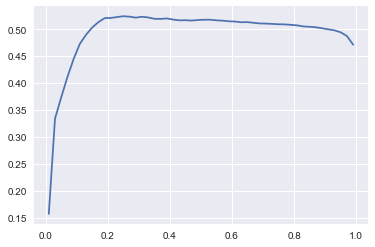

In [93]:
# pick the best threshold out-of-fold
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([f1_score(Y, X_preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())
print(best_threshold)

(6852,)
fold 0, ROC AUC: 0.910
0.468911917098
(6852,)
fold 1, ROC AUC: 0.910
0.505102040816
(6852,)
fold 2, ROC AUC: 0.915
0.493081761006
(6852,)
fold 3, ROC AUC: 0.909
0.505660377358
(6850,)
fold 4, ROC AUC: 0.911
0.498727735369
(6850,)
fold 5, ROC AUC: 0.916
0.534146341463
(6850,)
fold 6, ROC AUC: 0.915
0.496831432193
(6850,)
fold 7, ROC AUC: 0.912
0.503128911139
0.912270469164

0.52392578125
0.25

In [94]:
##create the submission file.
prediction_rfc=list(range(len(preds1)))
for i in range(len(preds1)):
    prediction_rfc[i]=1 if preds1[i]>best_threshold else 0

sub = pd.DataFrame({'employee_id': test_id, 'is_promoted': prediction_rfc})
sub=sub.reindex(columns=["employee_id","is_promoted"])
sub.to_csv('submission.csv', index=False)

In [179]:
##for OOF files generation.
os.chdir(r'C:\Users\royal\Downloads\wns\New folder')
prediction_rfc=list(range(len(preds1)))
for i in range(len(preds1)):
    prediction_rfc[i]=1 if preds1[i]>best_threshold else 0

sub = pd.DataFrame({'employee_id': test_id, 'is_promoted': prediction_rfc})
sub=sub.reindex(columns=["employee_id","is_promoted"])
filename = 'submission_test_'+'lgm_thres_'+str(mcc.max())+'.csv'
sub.to_csv(filename, index=False)


prediction_tr=list(range(len(X_preds)))
for i in range(len(X_preds)):
    prediction_tr[i]=1 if X_preds[i]>best_threshold else 0

sub = pd.DataFrame({'employee_id': train.is_promoted, 'is_promoted': prediction_tr})
sub=sub.reindex(columns=["employee_id","is_promoted"])
filename = filename = 'submission_train_'+'lgm_thres_'+str(mcc.max())+'.csv'
sub.to_csv(filename, index=False)

#######
sub = pd.DataFrame({'employee_id': test_id, 'is_promoted': preds1})
sub=sub.reindex(columns=["employee_id","is_promoted"])
filename = 'submission_test_'+'lgm_thres_pred_'+str(mcc.max())+'.csv'
sub.to_csv(filename, index=False)

sub = pd.DataFrame({'employee_id': train.employee_id, 'is_promoted': X_preds})
sub=sub.reindex(columns=["employee_id","is_promoted"])
filename = 'submission_train_'+'lgm_thres_pred_'+str(mcc.max())+'.csv'
sub.to_csv(filename, index=False)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.0941, max_depth=8, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=197,
        n_jobs=-1, num_leaves=17, objective=None, random_state=None,
        reg_alpha=3.4492, reg_lambda=0.0422, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

0.532352941176
0.35


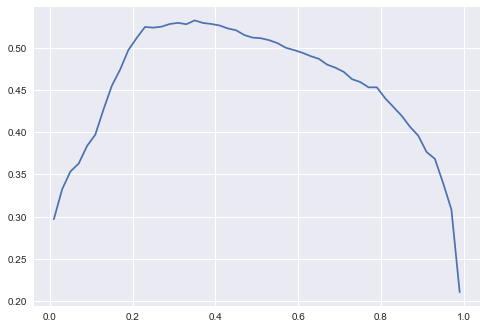

In [58]:
#done prediction using test train split
from sklearn.cross_validation import train_test_split
x,y = train3,Y
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)
clf = lgb.LGBMClassifier(max_depth= 8, learning_rate=0.0941, n_estimators=197, num_leaves= 17, reg_alpha=3.4492 , reg_lambda= 0.0422) #lgb_pca
clf.fit(x_train, y_train)

y_pred = clf.predict_proba(x_test)[:,1]
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([f1_score(y_test, y_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())
print(best_threshold)

y_pred1 = clf.predict_proba(test3)

In [88]:
os.chdir(r'C:\Users\royal\Downloads\wns\New folder\New folder')
meta=["lgm_pca_pred","lgm_pca1_pred","lgm_pca30_pred","lgm_pred","lgm_tune_pred","rgf_pred"]

meta_folder=""
y = np.loadtxt("train_LZdllcl.csv", delimiter=',',usecols=[13], skiprows=1)
Xmetatrain=None
Xmetatest=None
kk=0
for modelname in meta :
    mini_xtrain=np.loadtxt(meta_folder +'submission_train_'+ modelname + '.csv', delimiter=',',skiprows=1,usecols=range(1,2)) # we load the held out prediction of the int'train.csv' model
    mini_xtest=np.loadtxt(meta_folder + 'submission_test_' +modelname + '.csv', delimiter=',',skiprows=1,usecols=range(1,2))   # we load the test set prediction of the int'test.csv' model
    mean_train=np.mean(mini_xtrain) # we calclaute the mean of the train set held out predictions for reconciliation purposes
    mean_test=np.mean(mini_xtest)    # we calclaute the mean of the test set  predictions      
    if kk==0:
        kk=kk+1
        Xmetatrain=mini_xtrain
        Xmetatest=mini_xtest
    else :
        Xmetatrain=np.column_stack((Xmetatrain,mini_xtrain))
        Xmetatest=np.column_stack((Xmetatest,mini_xtest))
X=Xmetatrain
X_test=Xmetatest

,principal component 1,principal component 2,is_promoted
0,0.391762,-0.039531,0
1,-0.177524,0.018943,0
2,-0.196362,0.002029,0
3,-0.198872,-0.004405,0
4,-0.193101,-0.009436,0


Text(0.5,0,'Principal Component 1')

Text(0,0.5,'Principal Component 2')

Text(0.5,1,'2 Component PCA')

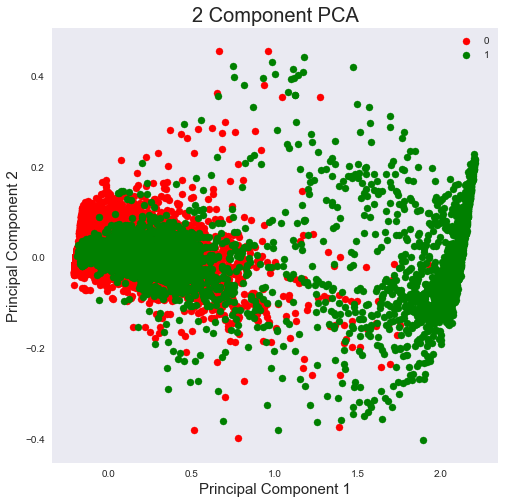

In [90]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, train.is_promoted], axis = 1)
finalDf.head(5)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['is_promoted'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [66]:
scaler = StandardScaler()
scaler.fit(X)
# Apply transform to both the training set and the test set.
X = scaler.transform(X)
X_test = scaler.transform(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [89]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X)
X  = min_max_scaler.transform(X)
X_test = min_max_scaler.transform(X_test)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [91]:
pca = PCA(n_components=2)
pca.fit(X)
train_pca = pca.transform(X)
test_pca = pca.transform(X_test)
train_X=np.column_stack((X,train_pca))
test_X=np.column_stack((X_test,test_pca))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [92]:
#Ensemble the models generated in first level.

st_train = train_X
st_test = test_X
clf = lgb.LGBMClassifier()
clf = LogisticRegression()
#clf = RGFClassifier(max_leaf=500,algorithm="RGF",test_interval=100, loss="LS")
# clf = Ridge()
# clf = lgb.LGBMClassifier(max_depth= 8, learning_rate=0.0941, n_estimators=197, num_leaves= 17, reg_alpha=3.4492 , reg_lambda= 0.0422) #lgb_pca
# clf=ExtraTreesClassifier(n_estimators=10000, criterion='entropy', max_depth=9,  min_samples_leaf=1,  n_jobs=30, random_state=1)

fold = 8
cv = StratifiedKFold(Y, n_folds=fold,shuffle=True, random_state=30)
X_preds = np.zeros(st_train.shape[0])
preds = np.zeros(st_test.shape[0])
for i, (tr, ts) in enumerate(cv):
    print(ts.shape)
    mod = clf.fit(st_train[tr], Y[tr])
    X_preds[ts] = mod.predict_proba(st_train[ts])[:,1]
    preds += mod.predict_proba(st_test)[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(Y[ts], X_preds[ts])))
    predictions = [round(value) for value in X_preds[ts]]
    print(f1_score(Y[ts], predictions))
score = roc_auc_score(Y, X_preds)
print(score)
preds1 = preds/fold

(6852,)
fold 0, ROC AUC: 0.907
0.477832512315
(6852,)
fold 1, ROC AUC: 0.910
0.51504211793
(6852,)
fold 2, ROC AUC: 0.914
0.516052318668
(6852,)
fold 3, ROC AUC: 0.910
0.517730496454
(6850,)
fold 4, ROC AUC: 0.910
0.507177033493
(6850,)
fold 5, ROC AUC: 0.917
0.550116550117
(6850,)
fold 6, ROC AUC: 0.916
0.525934861279
(6850,)
fold 7, ROC AUC: 0.912
0.533018867925
0.911935291552


In [96]:
os.chdir(r'C:\Users\royal\Downloads\wns\New folder\New folder\New folder')
os.listdir()

['submission.csv',
 'submission_ensemb.csv',
 'submission_test_lgm.csv',
 'submission_test_lgm_pca.csv',
 'submission_test_lgm_pca1.csv',
 'submission_test_lgm_pca30.csv',
 'submission_test_lgm_thres.csv',
 'submission_test_lgm_tune.csv',
 'submission_test_lgm_var.csv',
 'submission_test_rgf.csv',
 'submission_train_lgm.csv',
 'submission_train_lgm_pca.csv',
 'submission_train_lgm_pca1.csv',
 'submission_train_lgm_pca30.csv',
 'submission_train_lgm_thres.csv',
 'submission_train_lgm_tune.csv',
 'submission_train_lgm_var.csv',
 'submission_train_rgf.csv']

In [60]:
##simple average Blend.
preds1=(t1['is_promoted']+t6['is_promoted']+t3['is_promoted']+t4['is_promoted']+t5['is_promoted'])/6

prediction_rfc=list(range(len(preds1)))
for i in range(len(preds1)):
    prediction_rfc[i]=1 if preds1[i]>=0.60 else 0

sub = pd.DataFrame({'employee_id': test_id, 'is_promoted': prediction_rfc})
sub=sub.reindex(columns=["employee_id","is_promoted"])
filename = 'submission.csv'
sub.to_csv(filename, index=False)